In [1]:
#http://stat-computing.org/dataexpo/2009/the-data.html

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import timedelta,date
import datetime

In [66]:
# Data for the month of August in 2019 for all flights
data = pd.read_csv('C:/Users/saleh/Desktop/Airline/241868859_T_ONTIME_REPORTING.csv')

C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
airline_raw = data.sample(n=100000, random_state=100)
del data
airline_raw.head()
#data.describe()

,YEAR,MONTH,DAY_OF_MONTH,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,...,DIVERTED,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 31
19905,2019,8,26,DL,N3732J,3014,FAI,"Fairbanks, AK",Alaska,SEA,...,0.0,183.0,1.0,1533.0,NaN,NaN,NaN,NaN,NaN,NaN
92968,2019,8,8,WN,N7819A,1103,LAX,"Los Angeles, CA",California,HOU,...,0.0,178.0,1.0,1390.0,NaN,NaN,NaN,NaN,NaN,NaN
87542,2019,8,30,AS,N549AS,68,SIT,"Sitka, AK",Alaska,SEA,...,0.0,108.0,1.0,861.0,NaN,NaN,NaN,NaN,NaN,NaN
107699,2019,8,14,WN,N243WN,331,DEN,"Denver, CO",Colorado,OAK,...,0.0,125.0,1.0,957.0,12.0,0.0,0.0,0.0,63.0,NaN
317196,2019,8,29,YX,N632RW,3642,IAH,"Houston, TX",Texas,ATL,...,0.0,91.0,1.0,689.0,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
airline_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 19905 to 544756
Data columns (total 32 columns):
YEAR                   100000 non-null int64
MONTH                  100000 non-null int64
DAY_OF_MONTH           100000 non-null int64
OP_UNIQUE_CARRIER      100000 non-null object
TAIL_NUM               99879 non-null object
OP_CARRIER_FL_NUM      100000 non-null int64
ORIGIN                 100000 non-null object
ORIGIN_CITY_NAME       100000 non-null object
ORIGIN_STATE_NM        100000 non-null object
DEST                   100000 non-null object
DEST_CITY_NAME         100000 non-null object
DEST_STATE_NM          100000 non-null object
CRS_DEP_TIME           100000 non-null int64
DEP_TIME               98360 non-null float64
DEP_DELAY              98360 non-null float64
TAXI_OUT               98273 non-null float64
TAXI_IN                98239 non-null float64
CRS_ARR_TIME           100000 non-null int64
ARR_TIME               98239 non-null float64
ARR_DELAY         

In [69]:
airline_raw.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'OP_UNIQUE_CARRIER', 'TAIL_NUM',
       'OP_CARRIER_FL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM',
       'DEST', 'DEST_CITY_NAME', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'AIR_TIME',
       'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 31'],
      dtype='object')

## Understand and Fix NULL Values

In [70]:
missing = airline_raw.isnull().mean()*100
missing_values = pd.DataFrame({'column_name': airline_raw.columns,
                                 'percent_missing': missing})
print(missing_values)

                             column_name  percent_missing
YEAR                                YEAR            0.000
MONTH                              MONTH            0.000
DAY_OF_MONTH                DAY_OF_MONTH            0.000
OP_UNIQUE_CARRIER      OP_UNIQUE_CARRIER            0.000
TAIL_NUM                        TAIL_NUM            0.121
OP_CARRIER_FL_NUM      OP_CARRIER_FL_NUM            0.000
ORIGIN                            ORIGIN            0.000
ORIGIN_CITY_NAME        ORIGIN_CITY_NAME            0.000
ORIGIN_STATE_NM          ORIGIN_STATE_NM            0.000
DEST                                DEST            0.000
DEST_CITY_NAME            DEST_CITY_NAME            0.000
DEST_STATE_NM              DEST_STATE_NM            0.000
CRS_DEP_TIME                CRS_DEP_TIME            0.000
DEP_TIME                        DEP_TIME            1.640
DEP_DELAY                      DEP_DELAY            1.640
TAXI_OUT                        TAXI_OUT            1.727
TAXI_IN       

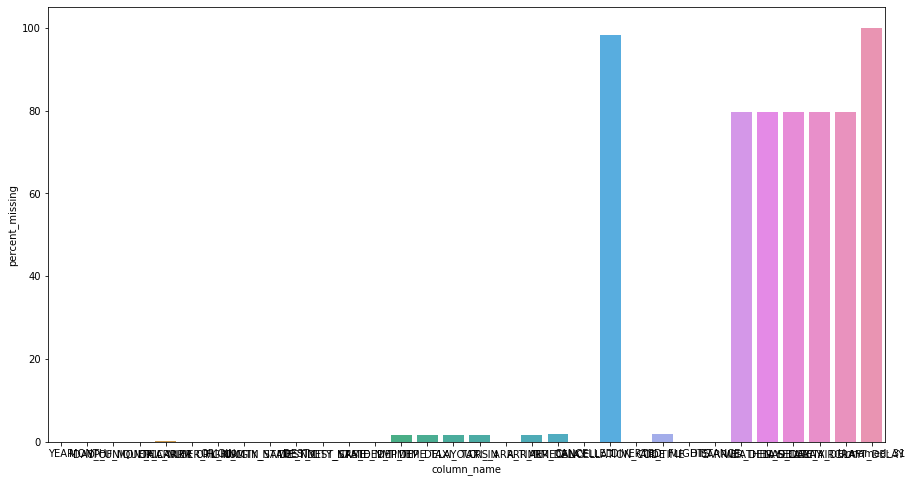

In [71]:
plt.figure(figsize=(15,8))
sns.barplot(x='column_name',y='percent_missing',data=missing_values)

In [72]:
airline_raw.columns = airline_raw.columns.str.lower() # lower case all column names for consistency

airline_raw = airline_raw.drop(airline_raw.columns[-1],axis=1) # drop last column

In [73]:
cancel = airline_raw[airline_raw.cancelled==1].copy() # get cancellation data in separate df

airline = airline_raw[airline_raw.cancelled==0].copy() # remove cancellation data from the full data

airline.drop(['cancelled','cancellation_code'], axis=1,inplace=True)

In [74]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98260 entries, 19905 to 544756
Data columns (total 29 columns):
year                   98260 non-null int64
month                  98260 non-null int64
day_of_month           98260 non-null int64
op_unique_carrier      98260 non-null object
tail_num               98260 non-null object
op_carrier_fl_num      98260 non-null int64
origin                 98260 non-null object
origin_city_name       98260 non-null object
origin_state_nm        98260 non-null object
dest                   98260 non-null object
dest_city_name         98260 non-null object
dest_state_nm          98260 non-null object
crs_dep_time           98260 non-null int64
dep_time               98260 non-null float64
dep_delay              98260 non-null float64
taxi_out               98260 non-null float64
taxi_in                98239 non-null float64
crs_arr_time           98260 non-null int64
arr_time               98239 non-null float64
arr_delay              98004 non

In [75]:
# convert date and months columns to datetime and remove individual columns

airline['date'] = pd.to_datetime(airline[['day_of_month','month','year']].astype(str).apply(' '.join, 1), format='%d %m %Y')

airline.drop(['day_of_month','month','year'], axis=1, inplace=True)

airline.head()

,op_unique_carrier,tail_num,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,dest,dest_city_name,dest_state_nm,crs_dep_time,...,diverted,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,date
19905,DL,N3732J,3014,FAI,"Fairbanks, AK",Alaska,SEA,"Seattle, WA",Washington,1455,...,0.0,183.0,1.0,1533.0,NaN,NaN,NaN,NaN,NaN,2019-08-26
92968,WN,N7819A,1103,LAX,"Los Angeles, CA",California,HOU,"Houston, TX",Texas,630,...,0.0,178.0,1.0,1390.0,NaN,NaN,NaN,NaN,NaN,2019-08-08
87542,AS,N549AS,68,SIT,"Sitka, AK",Alaska,SEA,"Seattle, WA",Washington,1015,...,0.0,108.0,1.0,861.0,NaN,NaN,NaN,NaN,NaN,2019-08-30
107699,WN,N243WN,331,DEN,"Denver, CO",Colorado,OAK,"Oakland, CA",California,1805,...,0.0,125.0,1.0,957.0,12.0,0.0,0.0,0.0,63.0,2019-08-14
317196,YX,N632RW,3642,IAH,"Houston, TX",Texas,ATL,"Atlanta, GA",Georgia,1020,...,0.0,91.0,1.0,689.0,NaN,NaN,NaN,NaN,NaN,2019-08-29


In [76]:
# check for NA in arrival time
airline.arr_delay.isnull().sum()

256

In [77]:
# Arrival delay column still has some NULL values, lets explore those.

airline[airline.arr_delay.isnull()==True].describe()

# Seems like all NAs are from flights which have been diverted. Lets verify that.

airline[airline.diverted==0].arr_delay.isnull().sum() # This verifies that no arrival time is listed for diverted flights.

0

In [78]:
# No arrival time listed for diverted flights, store diverted flights data in deparate df
divert = airline[airline.diverted==1].copy()
airline = airline[airline.diverted==0]
airline.drop(['diverted'], axis=1,inplace=True)

       op_unique_carrier tail_num  op_carrier_fl_num origin  \
64938                 YX   N437YX               4424    PVD   
617159                AA   N917AN               1259    BOS   
148217                UA   N13750               1464    ORF   
254115                DL   N922DL               2141    ORF   
293867                YV   N85355               6089    OKC   

         origin_city_name origin_state_nm dest  dest_city_name dest_state_nm  \
64938      Providence, RI    Rhode Island  DCA  Washington, DC      Virginia   
617159         Boston, MA   Massachusetts  MIA       Miami, FL       Florida   
148217        Norfolk, VA        Virginia  ORD     Chicago, IL      Illinois   
254115        Norfolk, VA        Virginia  ATL     Atlanta, GA       Georgia   
293867  Oklahoma City, OK        Oklahoma  IAH     Houston, TX         Texas   

        crs_dep_time  ...  arr_delay  air_time  flights  distance  \
64938           1336  ...     1035.0      60.0      1.0     356.0   
61

136220   -70.0
321127   -64.0
140470   -63.0
128585   -62.0
451507   -61.0
Name: arr_delay, dtype: float64

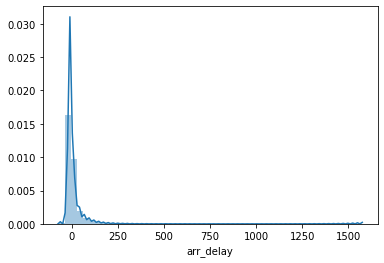

In [79]:
sns.distplot(airline.arr_delay)
airline.arr_delay.describe()

## Check max values for airline delay
airline.arr_delay.sort_values(ascending=False)
print(airline[airline.arr_delay>800].head()) # the delay looks legit and we will keep these extreme values

## Check min values for airline delay
airline.arr_delay.sort_values(ascending=True).head(5)


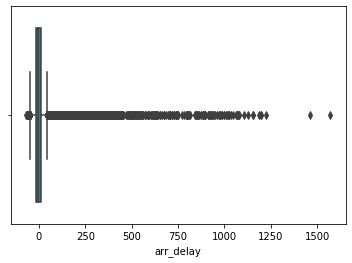

In [60]:
sns.boxplot(airline.arr_delay)

In [80]:
# make a flag for delayed flight. If the flight is more than 15 minutes late, then we will consider it as late.

airline['delayed'] = (airline.arr_delay > 15).astype('int')

In [81]:
airline.delayed.value_counts()

0    78338
1    19666
Name: delayed, dtype: int64

In [83]:
#sns.pairplot(airline)
#[['UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest']]
airline.origin_city_name.value_counts()
#airline.columns

Index(['op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin',
       'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
       'dest_state_nm', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out',
       'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay', 'air_time',
       'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'date', 'delayed'],
      dtype='object')

In [84]:

var = ['op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin',
       'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
       'dest_state_nm']
for v in var:
    airline[v] = airline[v].astype('category')


In [116]:
# only keep variables which will be used in model and are available before hand

airline_model = airline[['op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin',
                         'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
                         'dest_state_nm','crs_dep_time','crs_arr_time','air_time','distance','delayed']].copy()

In [126]:
# Check delayed flights by destination 

by_orig = airline_model.groupby('dest').agg(['sum', 'count'])['delayed'].sort_values(by='sum',ascending=False).cumsum()
#by_orig
by_orig = by_orig.reset_index()
#by_orig

Text(0.5, 1.0, 'Total Flights')

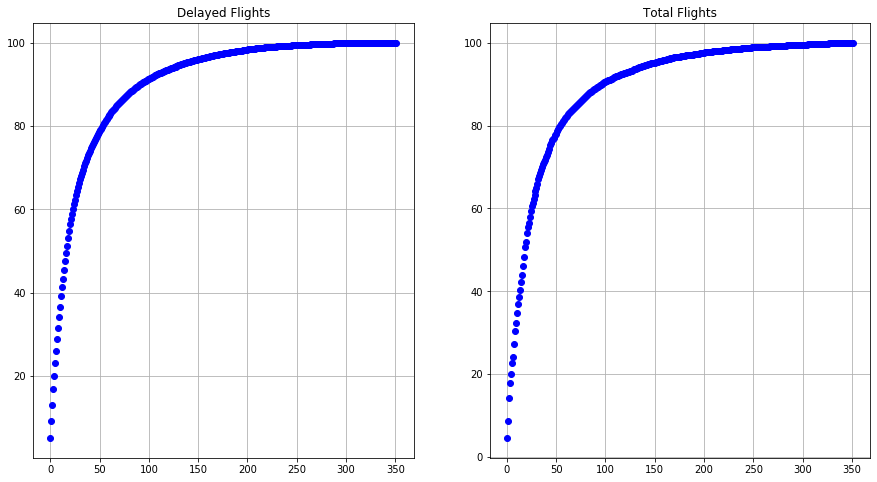

In [127]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.grid()
plt.plot(by_orig['sum']*100/by_orig['sum'].max(),'bo')
plt.title('Delayed Flights')

plt.subplot(1,2,2)
plt.grid()
plt.plot(by_orig['count']*100/by_orig['count'].max(),'bo')
plt.title('Total Flights')

In [130]:
# We choose top 100 cities, because that makes up more than 90% of data.
airline_top_100 = airline_model[airline_model['dest'].isin(by_orig.dest.head(100))]
airline_top_100.head(10)

,op_unique_carrier,tail_num,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,dest,dest_city_name,dest_state_nm,crs_dep_time,crs_arr_time,air_time,distance,delayed
19905,DL,N3732J,3014,FAI,"Fairbanks, AK",Alaska,SEA,"Seattle, WA",Washington,1455,1933,183.0,1533.0,0
92968,WN,N7819A,1103,LAX,"Los Angeles, CA",California,HOU,"Houston, TX",Texas,630,1145,178.0,1390.0,0
87542,AS,N549AS,68,SIT,"Sitka, AK",Alaska,SEA,"Seattle, WA",Washington,1015,1330,108.0,861.0,0
107699,WN,N243WN,331,DEN,"Denver, CO",Colorado,OAK,"Oakland, CA",California,1805,1940,125.0,957.0,1
317196,YX,N632RW,3642,IAH,"Houston, TX",Texas,ATL,"Atlanta, GA",Georgia,1020,1330,91.0,689.0,0
342157,MQ,N805AE,3634,ORF,"Norfolk, VA",Virginia,LGA,"New York, NY",New York,545,709,51.0,296.0,0
241344,WN,N239WN,3517,MDW,"Chicago, IL",Illinois,MSP,"Minneapolis, MN",Minnesota,825,950,58.0,349.0,0
332820,MQ,N809AE,3374,LGA,"New York, NY",New York,DTW,"Detroit, MI",Michigan,746,939,81.0,502.0,0
199915,AA,N119US,1722,LGA,"New York, NY",New York,CLT,"Charlotte, NC",North Carolina,1909,2123,82.0,544.0,0
242097,WN,N8677A,3750,SEA,"Seattle, WA",Washington,LAS,"Las Vegas, NV",Nevada,730,1000,110.0,867.0,0


In [110]:
airline_model.groupby('op_unique_carrier').mean()['delayed']

op_unique_carrier
9E    0.182190
AA    0.225082
AS    0.197823
B6    0.313123
DL    0.160104
EV    0.293544
F9    0.261631
G4    0.238450
HA    0.088504
MQ    0.203175
NK    0.261033
OH    0.239852
OO    0.175051
UA    0.227229
WN    0.158356
YV    0.220788
YX    0.228146
Name: delayed, dtype: float64

In [120]:
airline_model.corr()['delayed']

crs_dep_time    0.180022
crs_arr_time    0.151808
air_time        0.048703
distance        0.025747
delayed         1.000000
Name: delayed, dtype: float64

In [115]:
airline_model.flights.describe()

count    98004.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: flights, dtype: float64